In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

from seaborn import barplot
from seaborn import distplot

In [2]:
## to drop

notas = np.array(['NU_NOTA_CN','NU_NOTA_CH',
                  'NU_NOTA_LC','NU_NOTA_MT',
                  'NU_NOTA_REDACAO'])

drop_dados = [
    'NU_INSCRICAO', 'NO_MUNICIPIO_RESIDENCIA', 'SG_UF_RESIDENCIA',
    'CO_MUNICIPIO_NASCIMENTO','NO_MUNICIPIO_NASCIMENTO','CO_UF_NASCIMENTO',
    'SG_UF_NASCIMENTO']

drop_escola = [
    'CO_MUNICIPIO_ESC', 'NO_MUNICIPIO_ESC', 'CO_UF_ESC', 'SG_UF_ESC']

drop_prova = [
    'NO_MUNICIPIO_PROVA', 'CO_UF_PROVA', 'SG_UF_PROVA']

drop_deficiencia = [
    'IN_BAIXA_VISAO','IN_CEGUEIRA','IN_SURDEZ','IN_DEFICIENCIA_AUDITIVA',
    'IN_SURDO_CEGUEIRA','IN_DEFICIENCIA_FISICA','IN_DEFICIENCIA_MENTAL',
    'IN_DEFICIT_ATENCAO','IN_DISLEXIA','IN_DISCALCULIA','IN_AUTISMO',
    'IN_VISAO_MONOCULAR','IN_OUTRA_DEF']

drop_especifico = [
    'IN_GESTANTE','IN_LACTANTE','IN_IDOSO','IN_ESTUDA_CLASSE_HOSPITALAR']

drop_especializado = [
    'IN_SEM_RECURSO','IN_ACESSO','IN_BRAILLE','IN_AMPLIADA_24','IN_AMPLIADA_18','IN_LEDOR',
    'IN_ACESSO','IN_TRANSCRICAO','IN_LIBRAS','IN_TEMPO_ADICIONAL',
    'IN_LEITURA_LABIAL','IN_MESA_CADEIRA_RODAS','IN_MESA_CADEIRA_SEPARADA',
    'IN_APOIO_PERNA','IN_GUIA_INTERPRETE','IN_COMPUTADOR','IN_CADEIRA_ESPECIAL',
    'IN_CADEIRA_CANHOTO','IN_CADEIRA_ACOLCHOADA','IN_PROVA_DEITADO','IN_MOBILIARIO_OBESO',
    'IN_LAMINA_OVERLAY','IN_PROTETOR_AURICULAR','IN_MEDIDOR_GLICOSE','IN_MAQUINA_BRAILE',
    'IN_SOROBAN','IN_MARCA_PASSO','IN_SONDA','IN_MEDICAMENTOS','IN_SALA_INDIVIDUAL',
    'IN_SALA_ESPECIAL','IN_SALA_ACOMPANHANTE','IN_MOBILIARIO_ESPECIFICO',
    'IN_MATERIAL_ESPECIFICO','IN_NOME_SOCIAL']



In [3]:
## --- feat eng

## -- features socioeconomicos
def eng_dsoec( chunk ):

    chunk['Q001'] = chunk['Q001'].apply(lambda x: 1 if (x=='F') or (x=='G') 
                                              else 0).astype('int8')

    chunk['Q002'] = chunk['Q002'].apply(lambda x: 1 if (x=='F') or (x=='G') 
                                              else 0).astype('int8')

    chunk['Q01_2'] = chunk['Q001'] + chunk['Q002']
    chunk.drop(['Q001','Q002'], axis=1, inplace=True)

    chunk['Q003'] = chunk['Q003'].apply(lambda x: 1 if (x=='D') or (x=='E') 
                                              else 0).astype('int8')

    chunk['Q004'] = chunk['Q004'].apply(lambda x: 1 if (x=='D') or (x=='E') 
                                              else 0).astype('int8')

    chunk['Q03_4'] = chunk['Q003'] + chunk['Q004']
    chunk.drop(['Q003','Q004'], axis=1, inplace=True)

    chunk['Q005'] = chunk['Q005'].apply(lambda x: 1 if (x<=4) else
                                            2 if (x>4) and (x<=8) else 
                                            3 if (x>8) and (x<20) else 4).astype('int8')

    chunk['Q006'] = chunk['Q006'].apply(lambda x: 0 if (x<='C') else
                                            1 if (x>'C') and (x<='F') else
                                            2 if (x>'F') and (x<='I') else 3).astype('int8')
    
    chunk['Q007'] = chunk['Q007'].apply(lambda x: 0 if x=='A' else 1)
    
    chunk['Q008'] = chunk['Q008'].apply(lambda x: ord(x)- 65).astype('int8')
    chunk['Q009'] = chunk['Q009'].apply(lambda x: ord(x)- 65).astype('int8')
    chunk['Q08_9'] = (chunk['Q008'] + chunk['Q009']).astype('int8')
    chunk.drop(['Q008','Q009'], axis=1, inplace=True)
    chunk['Q08_9'] = chunk['Q08_9'].apply(lambda x: 0 if x<=3 else
                                                    1 if (x>3) and (x<=4) else
                                                    2 if (x>4) and (x<=6) else
                                                    3).astype('int8')
    
    ## --- total de veiculos por pessoa
    chunk['Q010'] = chunk['Q010'].apply(lambda x: ord(x)- 65).astype('int8')
    chunk['Q011'] = chunk['Q011'].apply(lambda x: ord(x)- 65).astype('int8')
    chunk['Q010_11'] = (chunk['Q010'] + chunk['Q011']).astype('int8')
    chunk.drop(['Q010','Q011'], axis=1, inplace=True)
    chunk['Q010_11'] = (chunk['Q010_11']/chunk['Q005']).astype('float16')
    
    ## -- total geladeira
    chunk['Q012'] = chunk['Q012'].apply(lambda x: ord(x)- 65).astype('int8')
    chunk['Q013'] = chunk['Q013'].apply(lambda x: ord(x)- 65).astype('int8')
    chunk['Q012_13'] = (chunk['Q012'] + chunk['Q013']).astype('int8')
    chunk['Q012_13'] = chunk['Q012_13'].apply(lambda x: 4 if x>= 4 else x)
    chunk.drop(['Q012','Q013'], axis=1, inplace=True)
    
    ## -- total lava/seca
    chunk['Q014'] = chunk['Q014'].apply(lambda x: ord(x)- 65).astype('int8')
    chunk['Q015'] = chunk['Q015'].apply(lambda x: ord(x)- 65).astype('int8')
    chunk['Q014_15'] = (chunk['Q014'] + chunk['Q015']).astype('int8')
    chunk.drop(['Q014','Q015'], axis=1, inplace=True)
    
    chunk['Q016'] = chunk['Q016'].apply(lambda x: ord(x)- 65).astype('int8')
    chunk['Q017'] = chunk['Q017'].apply(lambda x: ord(x)- 65).astype('int8')
    chunk['Q016_17'] = (chunk['Q016'] + chunk['Q017']).astype('int8')
    chunk.drop(['Q016','Q017'], axis=1, inplace=True)
    
    ## -- total sim/não
    chunk['S/N'] = ( chunk['Q018'].apply(lambda x: ord(x) - 65) +
                     chunk['Q020'].apply(lambda x: ord(x) - 65) +
                     chunk['Q021'].apply(lambda x: ord(x) - 65) +
                     chunk['Q023'].apply(lambda x: ord(x) - 65) +
                     chunk['Q025'].apply(lambda x: ord(x) - 65)).astype('int8')
    
    chunk.drop(['Q018','Q020','Q021','Q023','Q025'], axis=1, inplace=True)
    
    chunk['Q019'] = chunk['Q019'].apply(lambda x: 0 if x<='B' else
                                                  1 if x=='C' else
                                                  2)
    
    ## -- aparelho eletronico / pessoa
    chunk['Q022'] = chunk['Q022'].apply(lambda x: ord(x)- 65).astype('int8')
    chunk['Q024'] = chunk['Q024'].apply(lambda x: ord(x)- 65).astype('int8')
    chunk['Q022_24'] = (chunk['Q022'] + chunk['Q024']).astype('int8')
    chunk.drop(['Q022','Q024'], axis=1, inplace=True)
    chunk['Q022_24'] = (chunk['Q022_24']/chunk['Q005']).astype('float16')
    
    return chunk

## --- feat disab
def eng_scores(chunk):
    score_deficiencia = chunk[drop_deficiencia].sum(axis=1).astype('int8')
    score_especifico = chunk[drop_especifico].sum(axis=1).astype('int8')
    score_especializado = chunk[drop_especializado[1:]].sum(axis=1).astype('int8')
    
    return (score_deficiencia,
            score_especifico,
            score_especializado)

In [4]:
#df = pd.read_csv('train.csv',nrows=1)

reader = pd.read_csv('train.csv', chunksize=20000)

is_na = 0
lines = 0
with open('train_1st_eng.csv', 'w') as outFile:

    for chunk in reader:

        chunk.dropna(axis=0, how='all', inplace=True)
        
        ## -- conversão de tipos
        chunk['NU_IDADE'] = chunk['NU_IDADE'].fillna(chunk['NU_IDADE'].mean()).astype('int8')
        chunk['TP_STATUS_REDACAO'] = chunk['TP_STATUS_REDACAO'].fillna(0).astype('int8')

        ## -- feature engineering
        chunk['SCOR_DEFICIENCIA'], chunk['SCOR_ESPECIFICO'], chunk['SCOR_ESPECIALIZADO'] = eng_scores( chunk )
        chunk['NU_MED_NOTAS'] = chunk[notas].mean(axis=1)
        chunk = eng_dsoec(chunk)

        ## -- eliminação de dados pouco relevantes
        chunk.drop(np.concatenate((drop_deficiencia,
                        drop_especifico,
                        drop_especializado,
                        drop_dados,
                        drop_prova), axis=None), axis=1, inplace=True)
        chunk.drop(['TP_LINGUA'], axis=1, inplace=True)

        is_na = is_na + chunk.isna().sum(axis=0)
        lines = lines + len(chunk)

        ## -- removendo dados dos ausentes e eliminados
        chunk = chunk[(chunk['TP_PRESENCA_CN']+chunk['TP_PRESENCA_CH']+
                 chunk['TP_PRESENCA_LC']+chunk['TP_PRESENCA_MT']) ==4 ].copy()

        ## -- removendo redações anuladas (2,3,4,6,7,8,9)
        chunk = chunk[chunk['TP_STATUS_REDACAO']==1].copy()
        
        chunk.to_csv(outFile, header=None, index=False)
    

In [5]:
## -- identificando colunas com < 40% de missing values
cols    = is_na.index
to_read = is_na/lines < 0.4
to_read = {A:to_read.index.get_loc(A) for A in to_read.index if to_read[A] == True }

In [6]:
## -- detecção de outliers com IsolationForest
med_notas = pd.read_csv( 'train_1st_eng.csv', header=None, 
                   usecols=[to_read['NU_MED_NOTAS']] )

std = med_notas.std().values[0]
avg = med_notas.mean().values[0]

cont = round(len(med_notas[(med_notas[to_read['NU_MED_NOTAS']]>(avg+3*std)) | 
                    (med_notas[to_read['NU_MED_NOTAS']]<(avg-3*std))])/len(med_notas),3)

random_state = np.random.RandomState(42)
model = IsolationForest(n_estimators=100, max_samples='auto',
                        contamination=cont,random_state=random_state)

model.fit(med_notas[[to_read['NU_MED_NOTAS']]])

med_notas['anomaly_score'] = model.predict(med_notas[[to_read['NU_MED_NOTAS']]])

index_outliers = med_notas[med_notas['anomaly_score']==-1].index


In [7]:
with open('to_train.csv', 'w') as outFile:
    to_train = pd.read_csv('train_1st_eng.csv', usecols=list(to_read.values()), header=None)
    to_train.drop(index_outliers, axis=0, inplace=True)
    to_train.columns = [x for x in cols if x in list(to_read.keys())]
    to_train.to_csv(outFile, index=False)

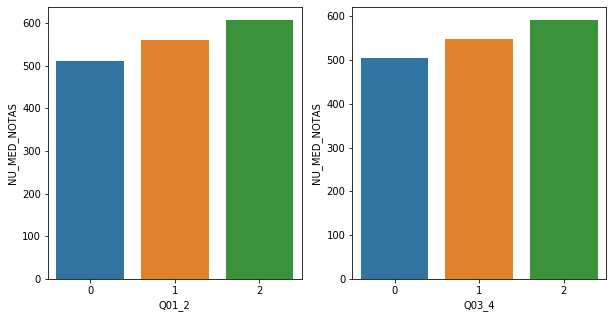

In [8]:
## --- EDA
fig, ax = plt.subplots(1,2, figsize=(10,5))

for axes, qn in zip(ax.reshape(-1), ['Q01_2','Q03_4']):
    data = pd.read_csv( 'to_train.csv', usecols=['NU_MED_NOTAS',qn] )
    barplot(x=qn, y='NU_MED_NOTAS',
            data=data, 
            order=data[qn].sort_values().unique(),
            ax= axes)
    axes.set_ylabel('NU_MED_NOTAS')
    axes.set_xlabel(qn)

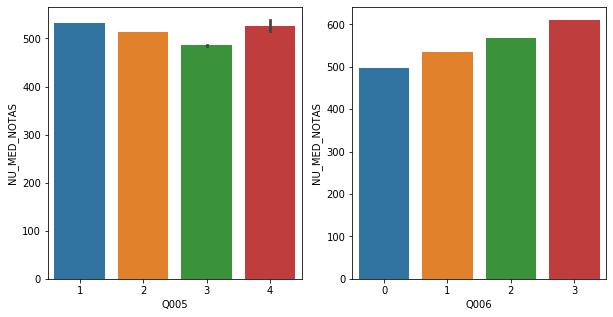

In [9]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

for axes, qn in zip(ax.reshape(-1), ['Q005','Q006']):
    data = pd.read_csv( 'to_train.csv', usecols=['NU_MED_NOTAS',qn] )
    barplot(x=qn, y='NU_MED_NOTAS',
            data=data, 
            order=data[qn].sort_values().unique(),
            ax=axes)
    axes.set_ylabel('NU_MED_NOTAS')
    axes.set_xlabel(qn)

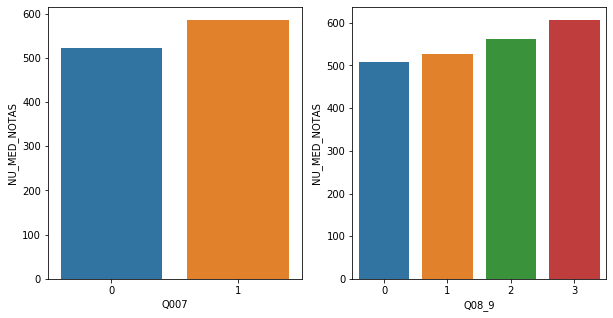

In [10]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

for axes, qn in zip(ax.reshape(-1), ['Q007','Q08_9']):
    data = pd.read_csv( 'to_train.csv', usecols=['NU_MED_NOTAS',qn] )
    barplot(x=qn, y='NU_MED_NOTAS',
            data=data, 
            order=data[qn].sort_values().unique(),
            ax= axes)
    axes.set_ylabel('NU_MED_NOTAS')
    axes.set_xlabel(qn)

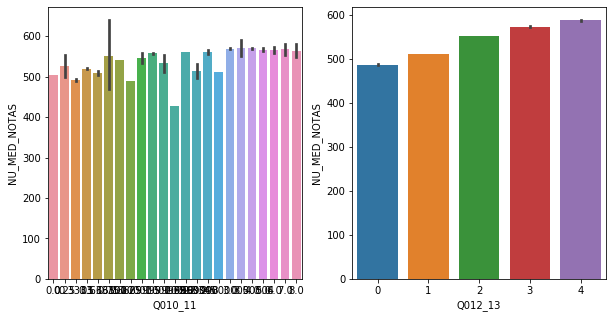

In [11]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

for axes, qn in zip(ax.reshape(-1), ['Q010_11','Q012_13']):
    data = pd.read_csv( 'to_train.csv',usecols=['NU_MED_NOTAS',qn] )
    barplot(x=qn, y='NU_MED_NOTAS',
            data=data, 
            order=data[qn].sort_values().unique(),
            ax= axes)
    axes.set_ylabel('NU_MED_NOTAS')
    axes.set_xlabel(qn)

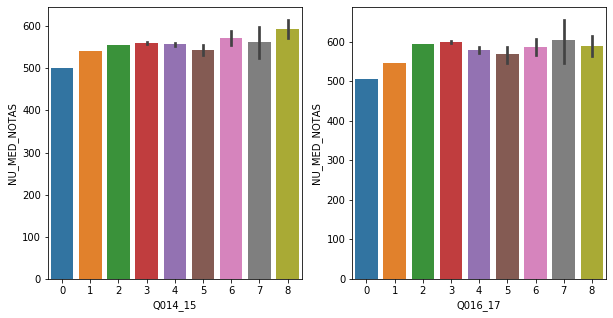

In [12]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

for axes, qn in zip(ax.reshape(-1), ['Q014_15','Q016_17']):
    data = pd.read_csv( 'to_train.csv', usecols=['NU_MED_NOTAS',qn] )
    barplot(x=qn, y='NU_MED_NOTAS',
            data=data, 
            order=data[qn].sort_values().unique(),
            ax= axes)
    axes.set_ylabel('NU_MED_NOTAS')
    axes.set_xlabel(qn)

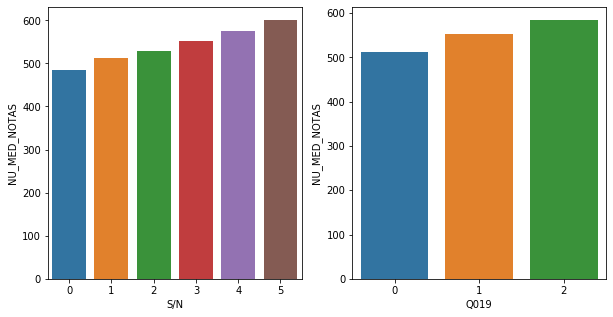

In [13]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

for axes, qn in zip(ax.reshape(-1), ['S/N','Q019']):
    data = pd.read_csv( 'to_train.csv', usecols=['NU_MED_NOTAS',qn] )
    barplot(x=qn, y='NU_MED_NOTAS',
            data=data, 
            order=data[qn].sort_values().unique(),
            ax= axes)
    axes.set_ylabel('NU_MED_NOTAS')
    axes.set_xlabel(qn)

Text(0.5, 0, 'Q022_24')

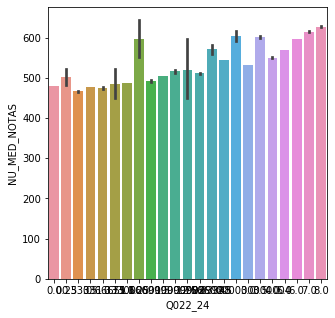

In [14]:
fig, ax = plt.subplots(1,1, figsize=(5,5))

axes, qn = (ax, 'Q022_24')
data = pd.read_csv( 'to_train.csv', usecols=['NU_MED_NOTAS',qn] )
barplot(x=qn, y='NU_MED_NOTAS',
        data=data, 
        order=data[qn].sort_values().unique(),
        ax= axes)
axes.set_ylabel('NU_MED_NOTAS')
axes.set_xlabel(qn)